In [1]:
import cv2
import os

# To resize images

# Folder paths
input_folder = "River vs Lake/lake water"  # Replace with your folder containing images
output_folder = "River vs Lake/resized_lake_water"  # Replace with your desired output folder

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)

    # Check if it's an image file (extensions may vary)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
        # Read the image
        image = cv2.imread(input_path)

        # Check if the image was successfully read
        if image is None:
            print(f"Could not read {filename}. Skipping...")
            continue

        # Resize the image to 256x256
        resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)

        # Save the resized image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, resized_image)

        print(f"Processed and saved: {output_path}")


Processed and saved: River vs Lake/resized_lake_water/Image_15.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_29.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_25.jpeg
Processed and saved: River vs Lake/resized_lake_water/Image_28.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_14.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_16.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_17.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_13.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_12.jpeg
Processed and saved: River vs Lake/resized_lake_water/Image_38.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_10.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_11.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_39.jpg
Processed and saved: River vs Lake/resized_lake_water/Image_76.JPG
Processed and saved: River vs Lake/resized_lake_water/Image_

In [2]:
import tensorflow as tf

dataset_path = "resized_lake_water"
image_size = (256, 256)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,  # No labels are required for unsupervised learning
    image_size=image_size,
    batch_size=batch_size
)

# Normalize the dataset and prepare (x, x) pairs
train_dataset = train_dataset.map(lambda x: (x / 255.0, x / 255.0))  # Input = Target

dataset_path = "Mixed"
image_size = (256, 256)
batch_size = 32

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,  # No labels are required for unsupervised learning
    image_size=image_size,
    batch_size=batch_size
)

# Normalize the dataset and prepare (x, x) pairs
test_dataset = test_dataset.map(lambda x: (x / 255.0, x / 255.0))  # Input = Target

2024-12-02 10:46:14.622721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 92 files belonging to 1 classes.


2024-12-02 10:46:35.428623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 10 files belonging to 1 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Autoencoder for RGB images
input_img = Input(shape=(256, 256, 3))  # Expecting RGB images
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Latent space
latent = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(latent)
x = UpSampling2D((2, 2))(x) # UpSampling2D is used to scale the feature maps back to the original image size (256x256).
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# The sigmoid activation is used to ensure the output pixel values are in the range [0, 1] (to match the normalized input).
decoded_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output RGB


# Compile and summarize the model
autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)
history = autoencoder.fit(train_dataset, epochs=50, callbacks=[early_stopping])



Epoch 1/50
3/3 [==============================] - 20s 5s/step - loss: 0.0091
Epoch 2/50
3/3 [==============================] - 14s 4s/step - loss: 0.0086
Epoch 3/50
3/3 [==============================] - 13s 4s/step - loss: 0.0084
Epoch 4/50
3/3 [==============================] - 14s 5s/step - loss: 0.0082
Epoch 5/50
3/3 [==============================] - 14s 4s/step - loss: 0.0080
Epoch 6/50
3/3 [==============================] - 15s 5s/step - loss: 0.0079
Epoch 7/50
3/3 [==============================] - 14s 4s/step - loss: 0.0078
Epoch 8/50
3/3 [==============================] - 16s 5s/step - loss: 0.0077
Epoch 9/50
3/3 [==============================] - 19s 6s/step - loss: 0.0075
Epoch 10/50
3/3 [==============================] - 17s 5s/step - loss: 0.0075
Epoch 11/50
3/3 [==============================] - 18s 6s/step - loss: 0.0074
Epoch 12/50
3/3 [==============================] - 18s 6s/step - loss: 0.0074
Epoch 13/50
3/3 [==============================] - 18s 6s/step - loss: 0.

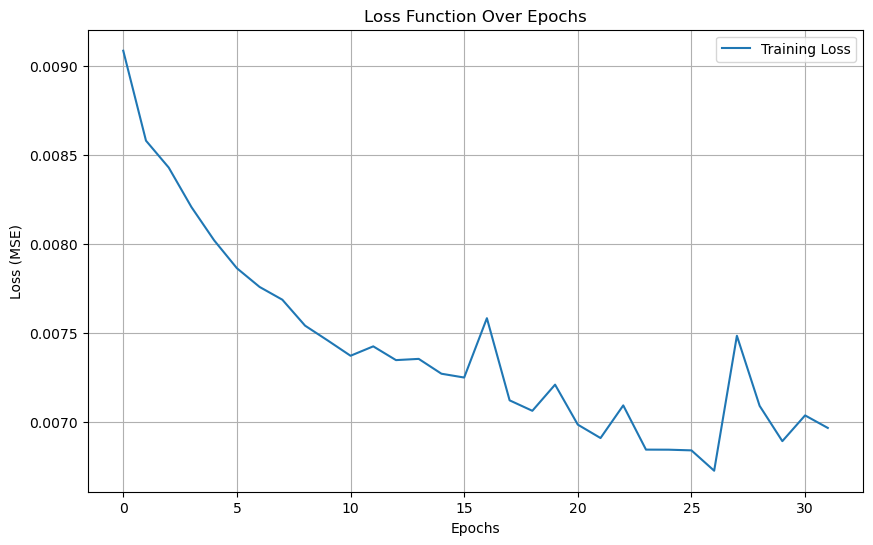

In [10]:


# Extract loss values
loss = history.history['loss']
val_loss = history.history.get('val_loss', None)  # Validation loss, if applicable

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label="Training Loss")
if val_loss:  # Add validation loss if available
    plt.plot(val_loss, label="Validation Loss")
plt.title("Loss Function Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 1s 667ms/step


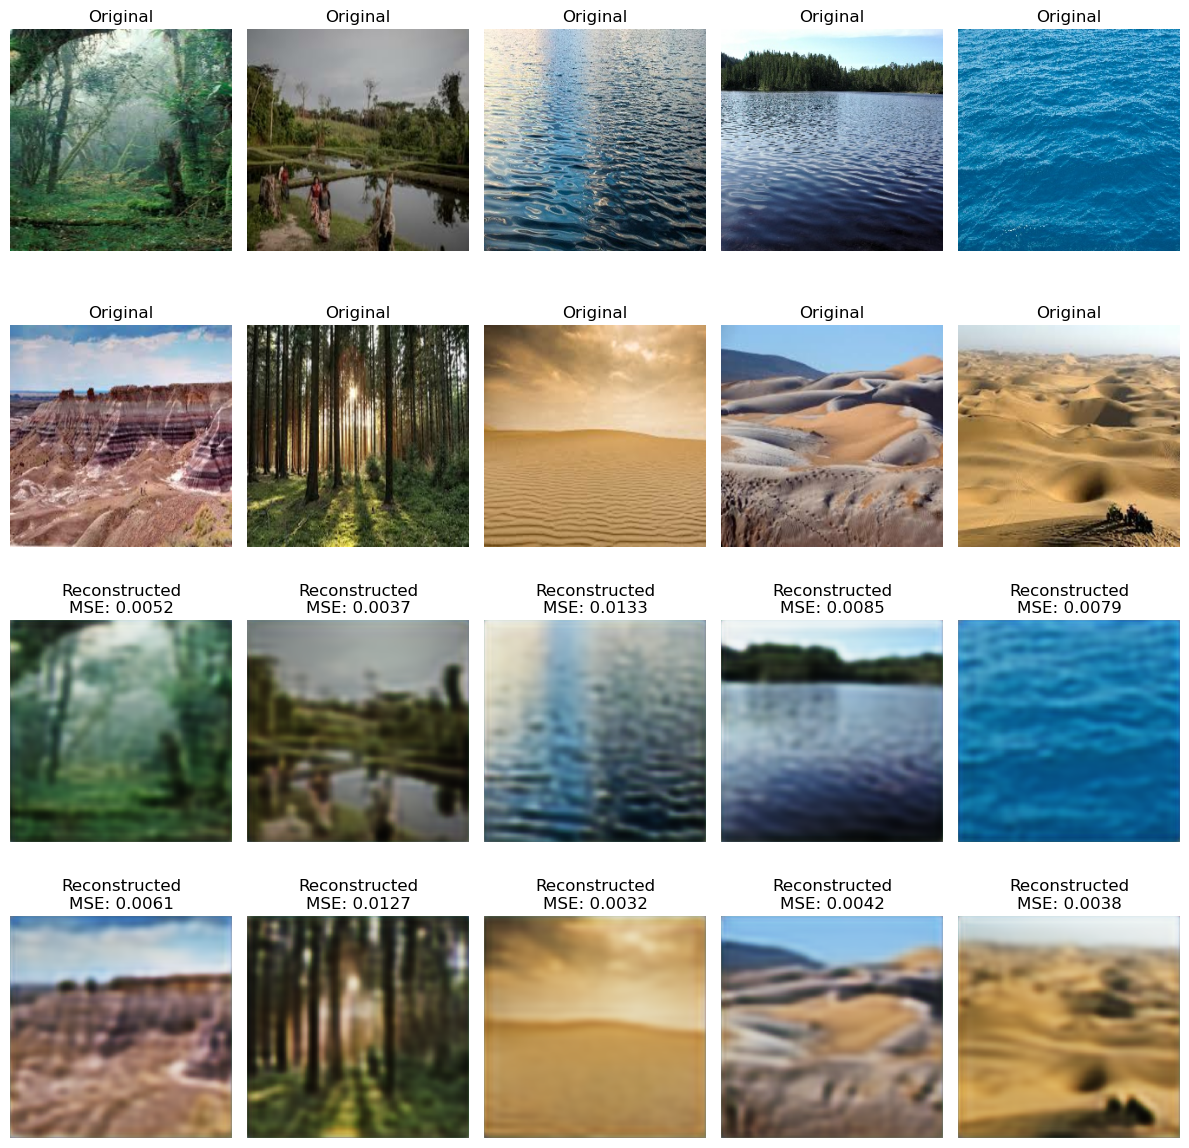

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the dataset
test_images = next(iter(test_dataset))

# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images[0])

# Calculate MSE for each image
mse = np.mean((test_images[0].numpy() - reconstructed_images) ** 2, axis=(1, 2, 3))

# Plot original and reconstructed images with MSE for 10 images in 4 rows
plt.figure(figsize=(12, 12))
for i in range(10):  # Loop over 10 images
    # Original image (Row 1 and 2)
    plt.subplot(4, 5, i + 1)  # First 10 slots for original images
    plt.imshow(test_images[0][i].numpy())
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image (Row 3 and 4)
    plt.subplot(4, 5, i + 11)  # Next 10 slots for reconstructed images
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed\nMSE: {mse[i]:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
